# SageMaker Model Debugging

Here we will see how we can use Sagemaker Debugging to see our model training performance as well as generate a simple report called the Profiler Report that gives us an overview of our training job.

First we will need to install `smdebug`.

## `pytorch_mnist.py`
<details>
  <summary> Click here to see the full script code </summary>
   
``` python
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# ====================================#
# 1. Import SMDebug framework class. #
# ====================================#
import smdebug.pytorch as smd


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(model, train_loader, optimizer, epoch, hook):
    model.train()
    # =================================================#
    # 2. Set the SMDebug hook for the training phase. #
    # =================================================#
    hook.set_mode(smd.modes.TRAIN)
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )

def test(model, test_loader, hook):
    model.eval()
    # ===================================================#
    # 3. Set the SMDebug hook for the validation phase. #
    # ===================================================#
    hook.set_mode(smd.modes.EVAL)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction="sum").item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(test_loader.dataset), 100.0 * correct / len(test_loader.dataset)
        )
    )


def main():
    # Training settings
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--batch-size",
        type=int,
        default=64,
        metavar="N",
        help="input batch size for training (default: 64)",
    )
    parser.add_argument(
        "--test-batch-size",
        type=int,
        default=1000,
        metavar="N",
        help="input batch size for testing (default: 1000)",
    )
    parser.add_argument(
        "--epochs",
        type=int,
        default=14,
        metavar="N",
        help="number of epochs to train (default: 14)",
    )
    parser.add_argument(
        "--lr", type=float, default=1.0, metavar="LR", help="learning rate (default: 1.0)"
    )
    args = parser.parse_args()
    
    train_kwargs = {"batch_size": args.batch_size}
    test_kwargs = {"batch_size": args.test_batch_size}

    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    )
    dataset1 = datasets.MNIST("../data", train=True, download=True, transform=transform)
    dataset2 = datasets.MNIST("../data", train=False, transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net()

    # ======================================================#
    # 4. Register the SMDebug hook to save output tensors. #
    # ======================================================#
    hook = smd.Hook.create_from_json_file()
    hook.register_hook(model)

    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    for epoch in range(1, args.epochs + 1):
        # ===========================================================#
        # 5. Pass the SMDebug hook to the train and test functions. #
        # ===========================================================#
        train(model, train_loader, optimizer, epoch, hook)
        test(model, test_loader, hook)

    torch.save(model.state_dict(), "mnist_cnn.pt")


if __name__ == "__main__":
    main()
```
</details>

In [3]:
!pip install smdebug

## Debugger Rule and Configs

Next we need to import the packages we will need and specify the debugger rules and configs. We will check for overfitting, overtraining, poor weight initialization and vanishing gradients. We will also set a save interval of 100 and 10 for training and testing respectively.

In [4]:
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    rule_configs,
)

In [5]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

In [6]:
hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

Next we will specify the hyperparameters and create our estimator. In our estimator, we will additionally need to specify the debugger rules and configs that we created before.

In [7]:
hyperparameters = {"epochs": "2", "batch-size": "32", "test-batch-size": "100", "lr": "0.001"}

In [8]:
estimator = PyTorch(
    entry_point="scripts/pytorch_mnist.py",
    base_job_name="smdebugger-mnist-pytorch",
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.large",
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
    ## Debugger parameters
    rules=rules,
    debugger_hook_config=hook_config,
)

In [9]:
estimator.fit(wait=True)

2022-01-07 14:22:15 Starting - Starting the training job...
2022-01-07 14:22:38 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport-1641565335: InProgress
......
2022-01-07 14:23:39 Starting - Preparing the instances for training......
2022-01-07 14:24:43 Downloading - Downloading input data...
2022-01-07 14:25:13 Training - Downloading the training image.....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-07 14:25:57,431 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-01-07 14:25:57,433 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-01-07 14:25:57,442 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-01-07 14:26:03,661 sagemaker_pytorch_container.training INFO     Inv

In [10]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

## Checking Training Performance
Below is some boilerplate code to get the training job object using the training job name and display the training metrics that we were tracking as well as some of the training tensors. The plots may not show up in the classroom, but it will show up when you train the model in SageMaker Studio.

In [11]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2022-01-07 14:33:57.466 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:502 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-01-07 14:33:57.489 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:502 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-152200895494/smdebugger-mnist-pytorch-2022-01-07-14-22-14-974/debug-output


Fetch tensor names and print their lengths

In [12]:
trial.tensor_names()

[2022-01-07 14:34:04.623 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:502 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-01-07 14:34:05.652 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:502 INFO trial.py:210] Loaded all steps


['gradient/Net_conv1.bias',
 'gradient/Net_conv1.weight',
 'gradient/Net_conv2.bias',
 'gradient/Net_conv2.weight',
 'gradient/Net_fc1.bias',
 'gradient/Net_fc1.weight',
 'gradient/Net_fc2.bias',
 'gradient/Net_fc2.weight',
 'nll_loss_output_0']

In [13]:
len(trial.tensor("nll_loss_output_0").steps(mode=ModeKeys.TRAIN))

38

In [14]:
len(trial.tensor("nll_loss_output_0").steps(mode=ModeKeys.EVAL))

20

Set up functions to plot the output tensors

In [15]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


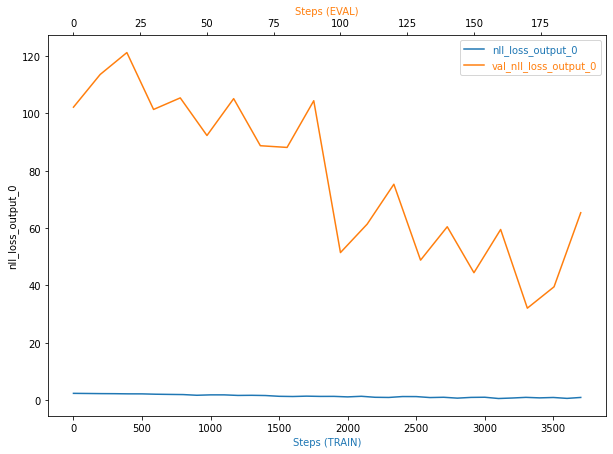

In [17]:
plot_tensor(trial, "nll_loss_output_0")

## Display the Profiler Report
The profiler report will be saved in an S3 bucket. Below we can see how to get the path of the report, fetch it and display it. The profiler report may not display in the notebook, but you can take a look at it from the ProfilerReport folder.

In [18]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [19]:
! aws s3 ls {rule_output_path} --recursive

2022-01-07 14:31:10     329724 smdebugger-mnist-pytorch-2022-01-07-14-22-14-974/rule-output/ProfilerReport-1641565335/profiler-output/profiler-report.html
2022-01-07 14:31:10     171092 smdebugger-mnist-pytorch-2022-01-07-14-22-14-974/rule-output/ProfilerReport-1641565335/profiler-output/profiler-report.ipynb
2022-01-07 14:31:06        191 smdebugger-mnist-pytorch-2022-01-07-14-22-14-974/rule-output/ProfilerReport-1641565335/profiler-output/profiler-reports/BatchSize.json
2022-01-07 14:31:06        199 smdebugger-mnist-pytorch-2022-01-07-14-22-14-974/rule-output/ProfilerReport-1641565335/profiler-output/profiler-reports/CPUBottleneck.json
2022-01-07 14:31:06        126 smdebugger-mnist-pytorch-2022-01-07-14-22-14-974/rule-output/ProfilerReport-1641565335/profiler-output/profiler-reports/Dataloader.json
2022-01-07 14:31:06        127 smdebugger-mnist-pytorch-2022-01-07-14-22-14-974/rule-output/ProfilerReport-1641565335/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-01-07 1

In [20]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-152200895494/smdebugger-mnist-pytorch-2022-01-07-14-22-14-974/rule-output/ProfilerReport-1641565335/profiler-output/profiler-reports/BatchSize.json to ProfilerReport-1641565335/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-152200895494/smdebugger-mnist-pytorch-2022-01-07-14-22-14-974/rule-output/ProfilerReport-1641565335/profiler-output/profiler-reports/Dataloader.json to ProfilerReport-1641565335/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-152200895494/smdebugger-mnist-pytorch-2022-01-07-14-22-14-974/rule-output/ProfilerReport-1641565335/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport-1641565335/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-152200895494/smdebugger-mnist-pytorch-2022-01-07-14-22-14-974/rule-output/ProfilerReport-1641565335/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerRepo

In [21]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [22]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")